In [1]:
%reload_ext autoreload
%autoreload 2
from numpy import genfromtxt
import numpy as np
import torch
from deepc_hunt.dynamics import CartpoleDx, RocketDx
from deepc_hunt import DeePC, Trainer
from deepc_hunt.controllers import npDeePC
from deepc_hunt.utils import tensor2np
import matplotlib.pyplot as plt
%matplotlib inline

### Data collection

In [2]:
# import gymnasium as gym
# import numpy as np
# import itertools
# import random

# import coco_rocket_lander  # need to import to call gym.make()


# # initialize data collection
# # PRBS INPUT
# PRBS_inputs = [(0.33, -1, -0.5), (0.33, 0, -1), (0.75, -1, 1), (0.33, 0, 0.5), 
#  (0, -1, 0), (0.33, -1, 1), (0.75, 0, -0.5), (0.75, 0, -1), (0.75, -1, 0.5), (0, 0, 0), 
#   (0.75, 1, 0.5), (0, 0, -0.5), (0.33, 1, 0), (0.75, 0, 0), (0.33, 0, 1), (0, -1, 1), (0.75, -1, -1), 
#    (0, -1, 0.5), (0.75, 1, 1), (0.33, 1, -0.5), (0, 1, -0.5), (0.33, 0, 0), (0, 1, 1), (0.75, 1, -1), 
#     (0.33, 1, 1), (0.75, -1, -0.5), (0.75, 1, -0.5), (0, 0, 1), (0.75, 0, 1), (0.33, -1, 0.5), (0, -1, -1), 
#      (0, 1, 0), (0.33, 0, -0.5), (0.75, 0, 0.5), (0, 0, 0.5), (0.33, -1, 0), (0.75, 1, 0), (0.75, -1, 0), 
#       (0, 0, -1), (0, 1, -1), (0.33, 1, -1), (0, -1, -0.5), (0.33, -1, -1), (0.33, 1, 0.5), (0, 1, 0.5)]
      
# PRBS_interval = 5 # Number of frames per input

# ############### RANDOM INPUT GENERATOR ###############

# # set1 = (0, 0.33, 0.75)
# # set2 = (-1, 0, 1)
# # set3 = (-1, -0.5, 0,  0.5, 1)

# # PRBS_inputs = list(itertools.product(set1, set2, set3))
# # random.shuffle(PRBS_inputs)
# # print("Number of PRBS inputs is:", len(PRBS_inputs))
# # print("PRBS input combinations are:", PRBS_inputs)

# #######################################################

# n = 6 # states
# m = 3 # inputs
# p = 6 # outputs

# T_past = 1 # number of past measurements (also called T_ini)
# T_future = 10 # number of future measurements (also called K)

# L = T_past + T_future # length of a data sequence
# print("Length of a data sequence:", L)

# T_hankel =  PRBS_interval*len(PRBS_inputs) #(m*L + n) + L - 1 # number of measurements used to fill Hankel Matrix

# print("Number of measurements to fill Hankel Matrix:", T_hankel)

# rank_hankel_theoretical = m*L + n # theoretical maximum rank of Hankel Matrix
# print("Theoretical maximum rank of Hankel Matrix:", rank_hankel_theoretical)

# u_data = np.zeros((T_hankel,m))
# y_data = np.zeros((T_hankel,p))
# print("Shape of u_data:", np.shape(u_data))
# print("Shape of y_data:", np.shape(y_data))


# # make environment and wrap video so that we can replay them later

# args = {
#     "initial_position": (0.5, 0.4, 0)
# }

# env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args)
# env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="DeePC_Data_Collection")

# # simulate
# step_count = 0
# max_steps = T_hankel

# obs, info = env.reset(seed=0)  # specify a random seed for consistency

# while True:
#     landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]

#     # PRBS INPUT
#     action = np.array(PRBS_inputs[step_count//PRBS_interval])
#     # print("Used PRBS input number:", step_count//PRBS_interval)

#     # collect data
#     u_data[step_count] = action
#     y_data[step_count] = obs[0:6]

#     next_obs, rewards, done, _, info = env.step(action)

#     # check if simulation ended
#     step_count += 1
#     if done or (step_count >= max_steps):
#         break

#     # update observation
#     obs = next_obs


# env.close()  


### Initialise controller

In [2]:
q = torch.Tensor([40,10,1,1,3000,30]) # 6-tuple (x, y, x_dot, y_dot, theta, theta_dot)
r = torch.Tensor([0.01,0.01,0.01]) # 3-tuple (F_E, F_S, phi)
q_np = tensor2np(q)
r_np = tensor2np(r)

n = 6 # states
m = 3 # inputs
p = 6 # outputs

Tini = 1 # number of past measurements (also called T_ini)
Tf = 10 # number of future measurements (also called K)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_batch = 1
ud = np.genfromtxt('data/rocket_ud.csv', delimiter=',')
yd = np.genfromtxt('data/rocket_yd.csv', delimiter=',')

y_constraints = np.ones(Tf*p)*1e5 #Unconstrained
u_constraints = np.ones(Tf*m)

# For training
controller = DeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic_y=True, stochastic_u=False, q=q, r=r, 
    lam_g1=torch.Tensor([1e-5]), lam_g2=torch.Tensor([10]), lam_y=torch.Tensor([1e5])
).to(device)

# For speed
np_controller = npDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, N=Tf, m=m, p=p, n=n
)
np_controller.setup(Q=np.diag(q_np), R=np.diag(r_np), lam_g1=1e-5, lam_g2=10, lam_y=1e5)

225
length of constraints before noise : 6
length of constraints after noise : 8


In [59]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

import coco_rocket_lander  # need to import to call gym.make()

args = {
    "initial_position": (0.4, 0.98, 0),  # 3-tuple (x, y, theta)
    # "initial_position": (0.2, 0.9, 0.2),
    # "enable_wind": True,
    "enable_moving_barge": True
}

# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args)
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="Michael_Model_Free_Dist")
obs, info = env.reset(seed=0)  # specify a random seed for consistency
rocket = RocketDx(x_init=torch.Tensor(obs[0:6]))
prev_state = torch.Tensor(obs[:6])
# initialize variables
step_count = 0
max_steps = 10
touched_ground = 0
landing_mode = 0
final_landing_position = []

# landing parameters
hover_height = 5
x_tol = 0.5
x_dot_tol = 0.3
theta_tol = 0.1

#Initial state for DeePC
u_past_sim = np.zeros(3*Tini)
y_past_sim = np.tile(obs[0:6],Tini)
torch_states = []
real_states = []

# simulate
pbar = tqdm(range(max_steps))
for _ in pbar:
    landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]

    if landing_mode == 0: # default mode: try to hover above platform
      deepc_reference = [0,0,0,0,0,0]
      deepc_reference[0] = landing_position[0]
      deepc_reference[1] = landing_position[1] + hover_height
      if ((abs(obs[0]-landing_position[0]) < x_tol) and (abs(obs[2]) < x_dot_tol) and (abs(obs[4]) < theta_tol)): # if only small errors left, enter landing mode
        print("Enter landing mode")
        landing_mode = 1
        deepc_reference = [0,0,0,0,0,0]
        deepc_reference[0] = landing_position[0]
        deepc_reference[1] = landing_position[1]
        final_landing_position = deepc_reference.copy()
    elif landing_mode == 1: # landing mode: land at fixed position (works better when using moving barge)
      deepc_reference = final_landing_position.copy()
    
    deepc_reference = np.tile(deepc_reference,Tf)

    # get action
    if((obs[6] and obs[7]) or touched_ground): # if both sensors touch the ground, stop
      action = [0,0,0]
      touched_ground = 1

    elif not touched_ground:
      # with torch.no_grad():
      #   _,u,_,_ = controller(
      #     uref=None,
      #     ref=torch.Tensor(deepc_reference),
      #     u_ini=torch.Tensor(u_past_sim),
      #     y_ini=torch.Tensor(y_past_sim)
      #   )
      #   action = tensor2np(u[0,:controller.m])
      action, _ = np_controller.solve(ref=deepc_reference, y_ini=y_past_sim, u_ini=u_past_sim)

    # store input & output for DeePC
    u_past_sim = np.append(u_past_sim[3:], action)
    y_past_sim = np.append(y_past_sim[6:], obs[0:6])

    # # apply action
    with torch.no_grad():
      # next_state = rocket(x=torch.Tensor(obs[0:6]), u=u[0,:controller.m])
      next_state = rocket(x=prev_state, u=torch.Tensor(action))
    
    next_obs, rewards, done, _, info = env.step(action)
    next_state[0,5] = torch.Tensor([next_obs[5]])
    next_state[0,2] = torch.Tensor([next_obs[2]])
    next_state[0,3] = torch.Tensor([next_obs[3]])
    torch_states.append(tensor2np(next_state[0,:]))
    # check if simulation ended
    step_count += 1
    if done or (step_count > max_steps):
        break

    # update observation
    obs = next_obs
    prev_state = next_state
    real_states.append(next_obs[0:6])
    # print(next_state[0,:])

    pbar.set_description(f'real x: {next_obs[0]:.2f}, torch: {next_state[0,0].item():.2f}, real y: {next_obs[1]:.2f}, torch: {next_state[0,1].item():.2f}\
, real theta: {next_obs[4]:.2f}, torch: {next_state[0,4].item():.2f}')

real_states = np.array(real_states)
torch_states = np.array(torch_states)
env.close()  # video saved at this step

/opt/homebrew/Caskroom/miniforge/base/envs/deepc-dev/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /Users/michaelcummins/DeePC-HUNT/examples/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


F_e = 6800000.0, F_s = 136000.0, Nozzle Torque : 500


real x: 13.35, torch: 13.35, real y: 26.37, torch: 26.40, real theta: -0.01, torch: -0.01: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Moviepy - Building video /Users/michaelcummins/DeePC-HUNT/examples/video/Michael_Model_Free_Dist-episode-0.mp4.
Moviepy - Writing video /Users/michaelcummins/DeePC-HUNT/examples/video/Michael_Model_Free_Dist-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/michaelcummins/DeePC-HUNT/examples/video/Michael_Model_Free_Dist-episode-0.mp4


In [60]:
torch_states

array([[ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, -7.7460207e-02],
       [ 1.3345298e+01,  2.6395674e+01,  1.3588797e-01, -1.9624814e+00,
        -6.4605465e-03, 

reals : (575, 6), torch : (575, 6)


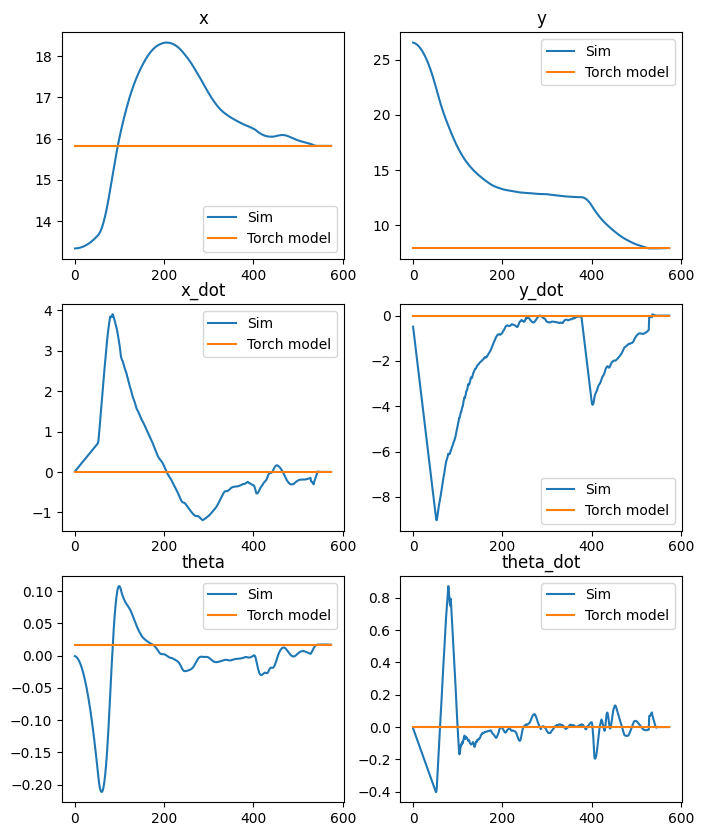

In [44]:
print(f'reals : {real_states.shape}, torch : {torch_states.shape}')
T = range(real_states.shape[0])
states = ['x', 'y', 'x_dot', 'y_dot', 'theta', 'theta_dot']

plt.figure(figsize=(8,10))
for i, state in enumerate(states):
    plt.subplot(3,2,i+1)
    plt.plot(T, real_states[:,i], label='Sim')
    plt.plot(T, torch_states[:,i], label='Torch model')
    # plt.xlabel('time')
    plt.title(state)
    plt.legend()
plt.show()